In [1]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

from train import conf
import glob
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import utils

import tqdm
import bvcopula
from vine import CVine

In [2]:
animal = 'ST260'
day_name = 'Day1'
exp_pref = f'{animal}_{day_name}'
path_models = f"{conf.path2outputs}/{exp_pref}"

In [3]:
list_files = glob.glob(f"{path_models}/models_*.pkl")

In [4]:
with open(f"{path_models}/models_layer0.pkl","rb") as f:
    results = pkl.load(f)
NN = len(results)+1
WAICs = np.zeros((NN,NN))
WAICs[0,1:] = [a[3] for a in results]
for layer in range(1,len(results)):
    with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
        res = pkl.load(f)
    WAICs[layer,(layer+1):] = [a[3] for a in res]

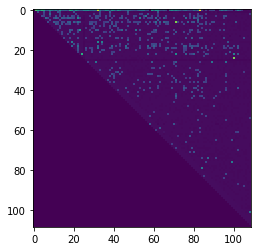

In [5]:
plt.imshow(WAICs[:])

In [6]:
device = "cuda:1"

# create linspace
N_points = 50
train_x = torch.linspace(0,1,N_points).to(device)

copula_layers, likelihood_layers, fs_layers = [], [], []
for layer in tqdm.tqdm(range(0,NN-1)):
    with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
        results = pkl.load(f)
    out_dir = f'{path_models}/layer{layer}'
    copulas, liks, fs = [], [], []
    for n,res in enumerate(results):
        if res[1]!='Independence':
            likelihoods = res[0]
            weights_file = f"{out_dir}/model_{exp_pref}_{layer}-{layer+n+1}.pth"
            model = utils.get_model(weights_file, likelihoods, device)
            liks.append(model.likelihood)
            with torch.no_grad():
                f = model(train_x).mean
                copula = model.likelihood.get_copula(f)
                copulas.append(copula)
                fs.append(f)
        else:
            copulas.append(bvcopula.MixtureCopula(torch.empty(1,0,device=device),
                    torch.ones(1,N_points,device=device),
                    [bvcopula.IndependenceCopula]))
            fs.append(None)
            liks.append([bvcopula.IndependenceCopula_Likelihood()])
    copula_layers.append(copulas)
    likelihood_layers.append(liks)
    fs_layers.append(fs)

100%|██████████| 108/108 [00:07<00:00, 14.42it/s]


In [22]:
# import time
# X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_unconditional.pkl")
# indep = bvcopula.MixtureCopula(torch.empty(1,0,device=device),
#                     torch.ones(1,1,device=device),
#                     [bvcopula.IndependenceCopula])
# N = Y.shape[-1]
# device = torch.device('cpu')
# data_layers = [torch.tensor(Y).float().to(device)]
# copula_layers = []
# t0 = time.time()
# for m in range(0,N-1):
#     copulas, layer = [], []
#     for n in tqdm.tqdm(range(1,N-m)):
#         samples = data_layers[-1][...,[n,0]]
#         likelihood = likelihood_layers[m][n-1]
#         f0 = fs_layers[m][n-1]
#         if f0 is None:
#             assert likelihood[0].name=='Independence'
#             copulas.append(indep)
#             layer.append(samples[:,0])
#         else:
#             f0 = f0.mean(axis=-1).unsqueeze(-1)
# #             copula0 = likelihood(f0)
#             copula = likelihood.fit(samples,f0)
# #             print(f"{m},{n+m}: {(copula0.theta-copula.theta).mean().cpu()}")
#             copulas.append(copula)
#             layer.append(copula.ccdf(samples.unsqueeze(-2)).squeeze())
#     data_layers.append(torch.stack(layer,dim=-1))
#     copula_layers.append(copulas)
# t1= time.time()
# print(f"{(t1-t0)//60}")

100%|██████████| 1/1 [00:00<00:00, 1369.35it/s]

32.0


In [7]:
vine = CVine(copula_layers,train_x,device=device)

In [11]:
%time Hrs = vine.entropy(sem_tol=.1, mc_size=4000, v=True)
Hrs

tensor(1.2406, device='cuda:1')
CPU times: user 1min 53s, sys: 24.3 s, total: 2min 18s
Wall time: 2min 10s


tensor([-17.4609, -17.5231, -18.0129, -18.5220, -19.2442, -19.9465, -20.4612,
        -20.7435, -20.9478, -21.0632, -21.1251, -21.0762, -21.3237, -20.8989,
        -20.3031, -19.6674, -19.1477, -18.2938, -17.8035, -17.2253, -16.8350,
        -16.2575, -15.9987, -15.5437, -15.3789, -15.2675, -15.2972, -15.4826,
        -15.5483, -15.9274, -16.0067, -16.2962, -16.4558, -16.7578, -17.3318,
        -17.8893, -18.2426, -18.8378, -21.0839, -22.1983, -22.3236, -21.9565,
        -20.0191, -18.2179, -16.5345, -15.3848, -14.3755, -13.9469, -14.0812,
        -14.4712], device='cuda:1')

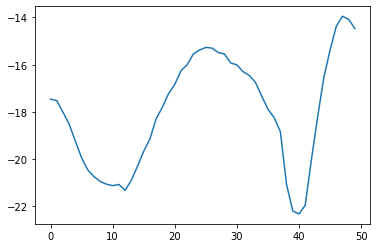

In [12]:
plt.plot(Hrs.cpu().numpy())

In [7]:
# vine_trained = CVine(copula_layers,torch.ones(1),device=device)
# with open(f"{home}vine_unconditional.pkl","wb") as f:
#     pkl.dump(vine_trained,f)
with open(f"{home}vine_unconditional.pkl","rb") as f:
    vine_trained = pkl.load(f)
# %time Hr = vine_trained.entropy(sem_tol=.1, mc_size=4000, v=True)

In [16]:
Hrs = []
Hr = []
uncond_layers = vine_trained.layers
for n in tqdm.tqdm(range(NN-1)):
    vine = CVine(copula_layers[n:],train_x,device=device)
    entropy = vine.entropy(sem_tol=0.1, mc_size=4000, v=False)
    Hrs.append(-entropy.mean().item())
    vine = CVine(uncond_layers[n:],torch.ones(1),device='cpu')
    entropy = vine.entropy(sem_tol=0.1, mc_size=4000, v=False)
    Hr.append(-entropy.mean().item())
    print(Hrs[-1]-Hr[-1])




  0%|          | 0/108 [00:00<?, ?it/s]


  1%|          | 1/108 [03:32<6:19:45, 212.95s/it]

-8.98849868774414





  2%|▏         | 2/108 [04:12<4:44:07, 160.82s/it]

-4.494027137756348





  3%|▎         | 3/108 [04:50<3:37:10, 124.10s/it]

-4.333754539489746





  4%|▎         | 4/108 [05:23<2:47:31, 96.65s/it] 

-4.263873100280762





  5%|▍         | 5/108 [05:48<2:09:20, 75.35s/it]

-3.244961738586426





  6%|▌         | 6/108 [06:13<1:42:11, 60.11s/it]

-2.8849782943725586





  6%|▋         | 7/108 [06:37<1:22:58, 49.29s/it]

-3.0167975425720215





  7%|▋         | 8/108 [06:55<1:06:47, 40.07s/it]

-1.8201985359191895





  8%|▊         | 9/108 [07:13<55:09, 33.43s/it]  

-1.6649036407470703





  9%|▉         | 10/108 [07:31<46:47, 28.65s/it]

-1.5085639953613281





 10%|█         | 11/108 [07:48<40:44, 25.20s/it]

-1.4947314262390137





 11%|█         | 12/108 [08:05<36:08, 22.59s/it]

-1.583958625793457





 12%|█▏        | 13/108 [08:21<32:36, 20.60s/it]

-1.6301631927490234





 13%|█▎        | 14/108 [08:36<29:55, 19.10s/it]

-1.6321015357971191





 14%|█▍        | 15/108 [08:47<25:53, 16.71s/it]

-1.5697436332702637





 15%|█▍        | 16/108 [08:58<22:53, 14.92s/it]

-1.678825855255127





 16%|█▌        | 17/108 [09:12<22:25, 14.78s/it]

-1.5660762786865234





 17%|█▋        | 18/108 [09:27<21:50, 14.57s/it]

-1.4471526145935059





 18%|█▊        | 19/108 [09:40<21:11, 14.28s/it]

-1.4160776138305664





 19%|█▊        | 20/108 [09:47<17:31, 11.95s/it]

-1.4727349281311035





 19%|█▉        | 21/108 [09:53<14:49, 10.22s/it]

-0.7036309242248535





 20%|██        | 22/108 [09:59<12:49,  8.95s/it]

-0.7393386363983154





 21%|██▏       | 23/108 [10:05<11:19,  8.00s/it]

-0.738717794418335





 22%|██▏       | 24/108 [10:10<10:09,  7.26s/it]

-0.03805947303771973





 23%|██▎       | 25/108 [10:16<09:17,  6.71s/it]

-0.08920931816101074





 24%|██▍       | 26/108 [10:21<08:36,  6.30s/it]

-0.6911792755126953





 25%|██▌       | 27/108 [10:26<08:03,  5.97s/it]

-0.7097605466842651





 26%|██▌       | 28/108 [10:31<07:34,  5.68s/it]

-0.6873419284820557





 27%|██▋       | 29/108 [10:36<07:10,  5.44s/it]

-0.7252267599105835





 28%|██▊       | 30/108 [10:41<06:49,  5.25s/it]

-0.6737239360809326





 29%|██▊       | 31/108 [10:45<06:30,  5.07s/it]

-0.6849420070648193





 30%|██▉       | 32/108 [10:50<06:12,  4.90s/it]

-0.708643913269043





 31%|███       | 33/108 [10:54<05:55,  4.74s/it]

-0.620288610458374





 31%|███▏      | 34/108 [10:59<05:39,  4.58s/it]

-0.6316018104553223





 32%|███▏      | 35/108 [11:03<05:23,  4.42s/it]

-0.6005414724349976





 33%|███▎      | 36/108 [11:06<05:07,  4.27s/it]

-0.5845087766647339





 34%|███▍      | 37/108 [11:10<04:52,  4.13s/it]

-0.5829399824142456





 35%|███▌      | 38/108 [11:14<04:37,  3.97s/it]

-0.5447982549667358





 36%|███▌      | 39/108 [11:17<04:24,  3.83s/it]

-0.45206785202026367





 37%|███▋      | 40/108 [11:21<04:11,  3.69s/it]

-0.57649827003479





 38%|███▊      | 41/108 [11:24<03:57,  3.55s/it]

-0.575827956199646





 39%|███▉      | 42/108 [11:27<03:45,  3.41s/it]

-0.4437180757522583





 40%|███▉      | 43/108 [11:30<03:32,  3.28s/it]

-0.36007261276245117





 41%|████      | 44/108 [11:33<03:22,  3.16s/it]

-0.3793907165527344





 42%|████▏     | 45/108 [11:36<03:11,  3.04s/it]

-0.42918938398361206





 43%|████▎     | 46/108 [11:38<03:01,  2.93s/it]

-0.380190372467041





 44%|████▎     | 47/108 [11:41<02:52,  2.82s/it]

-0.34530913829803467





 44%|████▍     | 48/108 [11:43<02:43,  2.72s/it]

-0.2515776753425598





 45%|████▌     | 49/108 [11:46<02:35,  2.63s/it]

-0.3383435010910034





 46%|████▋     | 50/108 [11:48<02:27,  2.54s/it]

-0.313163697719574





 47%|████▋     | 51/108 [11:50<02:20,  2.46s/it]

-0.2939803898334503





 48%|████▊     | 52/108 [11:53<02:13,  2.38s/it]

-0.2910690903663635





 49%|████▉     | 53/108 [11:55<02:06,  2.30s/it]

-0.28443068265914917





 50%|█████     | 54/108 [11:57<02:00,  2.23s/it]

-0.30271726846694946





 51%|█████     | 55/108 [11:59<01:53,  2.15s/it]

-0.3245478868484497





 52%|█████▏    | 56/108 [12:01<01:47,  2.07s/it]

-0.28001123666763306





 53%|█████▎    | 57/108 [12:02<01:41,  1.99s/it]

-0.30354997515678406





 54%|█████▎    | 58/108 [12:04<01:36,  1.92s/it]

-0.2926414906978607





 55%|█████▍    | 59/108 [12:06<01:30,  1.85s/it]

-0.246437668800354





 56%|█████▌    | 60/108 [12:08<01:25,  1.78s/it]

-0.243104487657547





 56%|█████▋    | 61/108 [12:09<01:20,  1.71s/it]

-0.2640480399131775





 57%|█████▋    | 62/108 [12:11<01:15,  1.64s/it]

-0.2279965877532959





 58%|█████▊    | 63/108 [12:12<01:10,  1.57s/it]

-0.24622395634651184





 59%|█████▉    | 64/108 [12:13<01:06,  1.50s/it]

-0.22972255945205688





 60%|██████    | 65/108 [12:15<01:01,  1.43s/it]

-0.1702144294977188





 61%|██████    | 66/108 [12:16<00:57,  1.37s/it]

-0.19887703657150269





 62%|██████▏   | 67/108 [12:17<00:53,  1.31s/it]

-0.14476320147514343





 63%|██████▎   | 68/108 [12:18<00:49,  1.25s/it]

-0.14799079298973083





 64%|██████▍   | 69/108 [12:19<00:46,  1.19s/it]

-0.09797266125679016





 65%|██████▍   | 70/108 [12:20<00:43,  1.14s/it]

-0.11003890633583069





 66%|██████▌   | 71/108 [12:21<00:39,  1.08s/it]

-0.11135551333427429





 67%|██████▋   | 72/108 [12:22<00:36,  1.03s/it]

-0.08374044299125671





 68%|██████▊   | 73/108 [12:23<00:34,  1.03it/s]

-0.029643699526786804





 69%|██████▊   | 74/108 [12:24<00:31,  1.08it/s]

-0.04091724753379822





 69%|██████▉   | 75/108 [12:24<00:28,  1.14it/s]

-0.042604148387908936





 70%|███████   | 76/108 [12:25<00:26,  1.22it/s]

-0.026961393654346466





 71%|███████▏  | 77/108 [12:26<00:23,  1.29it/s]

-0.020657658576965332





 72%|███████▏  | 78/108 [12:26<00:21,  1.38it/s]

-0.04351021349430084





 73%|███████▎  | 79/108 [12:27<00:19,  1.48it/s]

-0.05347283184528351





 74%|███████▍  | 80/108 [12:27<00:17,  1.58it/s]

-0.05042727291584015





 75%|███████▌  | 81/108 [12:28<00:15,  1.69it/s]

-0.04154233634471893





 76%|███████▌  | 82/108 [12:28<00:14,  1.81it/s]

-0.04249345511198044





 77%|███████▋  | 83/108 [12:29<00:12,  1.94it/s]

-0.04181957244873047





 78%|███████▊  | 84/108 [12:29<00:11,  2.09it/s]

-0.054771699011325836





 79%|███████▊  | 85/108 [12:30<00:10,  2.25it/s]

-0.03712388500571251





 80%|███████▉  | 86/108 [12:30<00:08,  2.44it/s]

-0.028520900756120682





 81%|████████  | 87/108 [12:30<00:07,  2.65it/s]

-0.018370669335126877





 81%|████████▏ | 88/108 [12:30<00:06,  2.88it/s]

-0.026115629822015762





 82%|████████▏ | 89/108 [12:31<00:06,  3.14it/s]

-0.02516002766788006





 83%|████████▎ | 90/108 [12:31<00:05,  3.46it/s]


 84%|████████▍ | 91/108 [12:31<00:04,  3.83it/s]

-0.01902862172573805
-0.01513446494936943





 85%|████████▌ | 92/108 [12:31<00:03,  4.22it/s]


 86%|████████▌ | 93/108 [12:32<00:03,  4.68it/s]

-0.017999108880758286
-0.01673965249210596





 87%|████████▋ | 94/108 [12:32<00:02,  5.19it/s]


 88%|████████▊ | 95/108 [12:32<00:02,  5.76it/s]

-0.023791064508259296
-0.02028909418731928





 89%|████████▉ | 96/108 [12:32<00:01,  6.42it/s]


 90%|████████▉ | 97/108 [12:32<00:01,  7.19it/s]

-0.024165880866348743
-0.015973900444805622
-0.009233260527253151





 92%|█████████▏| 99/108 [12:32<00:01,  8.24it/s]


 94%|█████████▎| 101/108 [12:32<00:00,  9.74it/s]

-0.01627273578196764
-0.02063532266765833
-0.018529686145484447
-0.015705130994319916
0.0





100%|██████████| 108/108 [12:32<00:00,  6.97s/it]

0.0
0.0
0.0
0.0
0.0


In [29]:
# mem = (Hrs, Hr)
# with open(f"{home}_MI_decorr.pkl","wb") as f:
#     pkl.dump((Hrs,Hr),f)

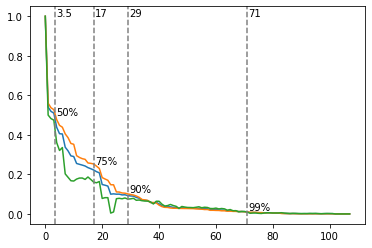

In [17]:
Hrs = np.array(Hrs)
Hr = np.array(Hr)
plt.plot(Hr/Hr[0])
plt.plot(Hrs/Hrs[0])
plt.plot((Hrs-Hr)/(Hrs[0]-Hr[0]))
# plt.axhline(0.01,c='black',linestyle='dashed')
plt.axvline(3.5,c='grey',linestyle='dashed')
plt.axvline(17,c='grey',linestyle='dashed')
plt.axvline(29,c='grey',linestyle='dashed')
plt.axvline(71,c='grey',linestyle='dashed')
plt.text(3.8,1.0,'3.5')
plt.text(17.5,1.0,'17')
plt.text(29.5,1.0,'29')
plt.text(71.5,1.0,'71');
plt.text(3.8,0.5,'50%')
plt.text(17.5,0.25,'75%')
plt.text(29.5,0.11,'90%')
plt.text(71.5,0.02,'99%');

In [8]:
Hrs = []
Hr = []
uncond_layers = vine_trained.layers
vineC = CVine(copula_layers,train_x,device=device)
vineU = CVine(uncond_layers,torch.ones(1),device='cpu')
for n in tqdm.tqdm([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104,105,106,107,108]):
    entropy = vineC.truncate(n).entropy(sem_tol=0.1, mc_size=4000, v=False)
    Hrs.append(entropy.mean().item())
    entropy = vineU.truncate(n).entropy(sem_tol=0.1, mc_size=4000, v=False)
    Hr.append(entropy.mean().item())
    print(Hrs[-1]-Hr[-1])

  5%|▌         | 1/19 [03:53<1:09:59, 233.33s/it]

9.122200012207031


 11%|█         | 2/19 [07:41<1:05:40, 231.79s/it]

9.097492218017578


 16%|█▌        | 3/19 [11:28<1:01:25, 230.37s/it]

9.088386535644531


 21%|██        | 4/19 [15:21<57:47, 231.19s/it]  

9.030937194824219


 26%|██▋       | 5/19 [19:20<54:29, 233.52s/it]

9.06710433959961


 32%|███▏      | 6/19 [23:09<50:17, 232.12s/it]

8.900018692016602


 37%|███▋      | 7/19 [26:56<46:07, 230.62s/it]

8.731073379516602


 42%|████▏     | 8/19 [30:40<41:53, 228.54s/it]

8.741296768188477


 47%|████▋     | 9/19 [34:15<37:26, 224.66s/it]

8.58769416809082


 53%|█████▎    | 10/19 [37:41<32:51, 219.07s/it]

7.911664962768555


 58%|█████▊    | 11/19 [40:33<27:17, 204.70s/it]

7.778922080993652


 63%|██████▎   | 12/19 [43:29<22:54, 196.32s/it]

7.603995323181152


 68%|██████▊   | 13/19 [45:44<17:47, 177.91s/it]

6.593308448791504


 74%|███████▎  | 14/19 [47:53<13:36, 163.23s/it]

6.656498908996582


 79%|███████▉  | 15/19 [49:54<10:01, 150.36s/it]

6.094379425048828


 84%|████████▍ | 16/19 [51:50<07:00, 140.27s/it]

5.104525566101074


 89%|████████▉ | 17/19 [53:45<04:25, 132.62s/it]

5.183718681335449


 95%|█████████▍| 18/19 [55:34<02:05, 125.61s/it]

5.058732032775879


100%|██████████| 19/19 [55:41<00:00, 175.89s/it]

0.0


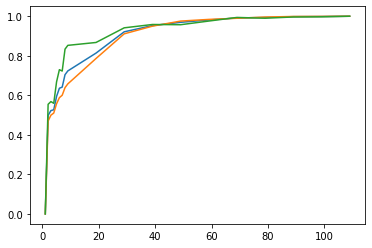

In [13]:
Hrs = np.array(Hrs)
Hr = np.array(Hr)
ns = 109-np.array([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104,105,106,107,108])
plt.plot(ns,Hr/Hr[0])
plt.plot(ns,Hrs/Hrs[0])
plt.plot(ns,(Hrs-Hr)/(Hrs[0]-Hr[0]))
# plt.axhline(0.01,c='black',linestyle='dashed')

In [7]:
conditional_model = copula_layers[0][31]
theta0 = conditional_model.theta.mean(axis=-1)
mix0 = conditional_model.mix.mean(axis=-1)
copula = bvcopula.MixtureCopula(theta0,mix0,conditional_model.copulas,rotations=conditional_model.rotations)
copula.entropy()

tensor(-0.0266)

In [8]:
X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_unconditional.pkl")
samples = torch.tensor(Y[:,[0,32]]).float().to(theta0.device)

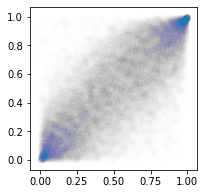

In [9]:
plt.figure(figsize=(3,3))
plt.scatter(*Y[:,[0,2]].T,alpha=0.005)

In [10]:
f0 = fs_layers[0][31].mean(axis=-1).unsqueeze(-1)
likelihood = likelihood_layers[0][31]
likelihood(f0).mix, mix0

(tensor([[0.6428],
         [0.1772],
         [0.1800]]), tensor([0.6082, 0.2148, 0.1770]))

In [11]:
samples = torch.tensor(Y[:,[0,33]]).float().to(device)
f0 = fs_layers[0][32].mean(axis=-1).unsqueeze(-1)
likelihood = likelihood_layers[0][32].to(device)
%time copula = likelihood.fit(samples,f0)
# %time copula, plot_loss = train(samples)

CPU times: user 10.2 s, sys: 184 ms, total: 10.4 s
Wall time: 5.55 s


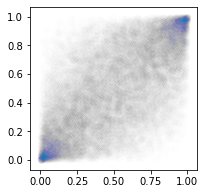

In [290]:
plt.figure(figsize=(3,3))
plt.scatter(*copula.sample(torch.Size([20000])).cpu().numpy().T,alpha=0.005)

In [9]:
samples = vine.sample(torch.Size([100]))

In [111]:
indep = bvcopula.MixtureCopula(torch.empty(1,0,device=device),
                    torch.ones(1,N_points,device=device),
                    [bvcopula.IndependenceCopula])
truncated_layers = [[model for model in layer] for layer in copula_layers]
Ncut = (NN-3)-1
for i in range(1,Ncut+1):
    for j in range(i):
        truncated_layers[-i][j] = indep
vine = CVine(truncated_layers,train_x,device=device)

In [112]:
entropy2 = vine.entropy(sem_tol=0.1, mc_size=4000, v=True)

tensor(1.1057, device='cuda:1')


In [116]:
entropy2.mean()/entropy.mean()

tensor(0.5101, device='cuda:1')

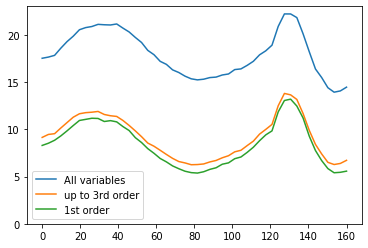

In [118]:
x = np.linspace(0,160,N_points)
plt.plot(x,-entropy.cpu().numpy(), label="All variables")
plt.plot(x,-entropy2.cpu().numpy(), label="up to 3rd order")
plt.plot(x,-entropy3.cpu().numpy(), label="1st order")
plt.ylim(0,23)
plt.legend();

Text(0, 0.5, 'Entropy')

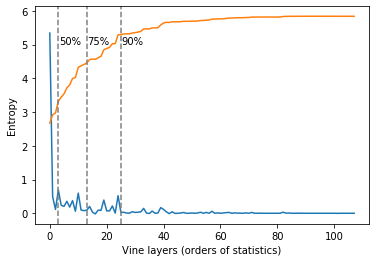

In [17]:
np_repeats = np.array(repeats)
H_layers = np_repeats.mean(axis=0)[::-1]
plt.plot(H_layers)
plt.plot(H_layers.cumsum()/2)
plt.axvline(3,color='grey',linestyle='dashed')
plt.axvline(13,color='grey',linestyle='dashed')
plt.axvline(25,color='grey',linestyle='dashed')
plt.text(3.2,5,'50%')
plt.text(13.2,5,'75%')
plt.text(25.2,5,'90%')
plt.xlabel('Vine layers (orders of statistics)')
plt.ylabel('Entropy')

In [ ]:
H_layers[0].sum()/H_layers.sum()

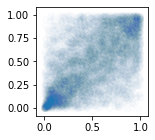

In [65]:
plt.figure(figsize=(2,2))
layer0 = layers[-1]
plt.scatter(layer0[0],layer0[3],alpha=0.01)

In [ ]:
plt.figure(figsize=(2,2))
plt.scatter(samples[...,0].cpu().numpy(),new_samples[...,-1].cpu().numpy(),alpha=0.01)

In [12]:
def generate_samples(samples,NN):
    layers = []
    for layer in torch.arange(NN-1,0):
        # load models for a layer
        with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
            results = pkl.load(f)
        # assign memory for a new layer samples
        new_layer_shape = torch.Size([N_points])+sample_size+torch.Size([NN-1-layer])
        new_samples = torch.empty(size=new_layer_shape, device=device)
        # transfrom samples
        transform(X,layers[-1],new_samples,layer,results)
        # store the result
        layers.append(new_samples.clone())
    return layers
%time samples = generate_samples(samples,NN)

CPU times: user 2min 8s, sys: 529 ms, total: 2min 8s
Wall time: 13.6 s


In [13]:
len(samples)

109